# Implementation the Random Forest Kernel

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from scipy import misc

## 1 Setup for RFK

### 1.1 Load MNIST

In [2]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(len(x_train),-1)
x_test = x_test.reshape(len(x_test),-1)

# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 784)
Number of images in x_train 60000
Number of images in x_test 10000


### 1.2 Build a Random Forrest Classifier

In [4]:
# TODO
# One thing that will play a huge role in this is changing the depth.. smaller depth equates to higher chance of 
# two images falling into the same node

In [5]:
RF = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
RF.fit(x_train[:500], y_train[:500])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [14]:
# Check the accuracy
count = 0.0
sum(RF.predict(x_test) == y_test)/len(y_test)

0.77390000000000003

In [17]:


final_nodes = RF.apply(x_train[:500])
final_nodes

array([[ 5, 27, 36, ..., 57, 28, 23],
       [ 9, 56, 55, ..., 25, 11, 36],
       [ 5, 41, 36, ...,  5, 34, 16],
       ..., 
       [ 8, 31,  5, ...,  8, 22, 46],
       [28, 27, 36, ..., 12, 49, 15],
       [23, 50, 47, ..., 49, 13, 44]])

In [8]:
%%time
num_data = 500

num_trees = final_nodes.shape[1]
P = np.zeros((num_data,num_data))

# For each tree
for j in range(100):
    tmp_P = []
    for i in range(num_data):        
        s = np.array([int(final_nodes[i][j] == leaf) for leaf in final_nodes[:, j]])
        tmp_P.append(s)
    P += np.array(tmp_P)

CPU times: user 24.4 s, sys: 199 ms, total: 24.6 s
Wall time: 25.4 s


In [24]:
row_sum = np.sum(P, axis=1).reshape(-1, 1)
P_normed = P / row_sum

In [25]:
# Unnormalized counts
P_normed

array([[ 0.02422481,  0.0004845 ,  0.00242248, ...,  0.00072674,
         0.00290698,  0.00096899],
       [ 0.00062913,  0.03145643,  0.        , ...,  0.00031456,
         0.00062913,  0.        ],
       [ 0.00235849,  0.        ,  0.02358491, ...,  0.00117925,
         0.00188679,  0.        ],
       ..., 
       [ 0.00083172,  0.00027724,  0.00138619, ...,  0.02772387,
         0.00110895,  0.00304963],
       [ 0.0034632 ,  0.0005772 ,  0.0023088 , ...,  0.0011544 ,
         0.02886003,  0.0011544 ],
       [ 0.00146735,  0.        ,  0.        , ...,  0.00403522,
         0.00146735,  0.03668379]])

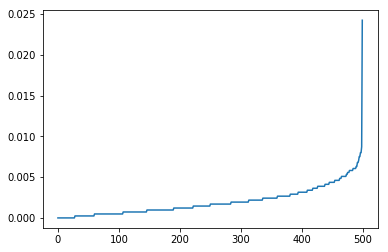

In [26]:
plt.ylim=1
plt.plot(np.arange(500), sorted(P_normed[0,:]))
plt.show()

In [27]:
from sklearn.ensemble import RandomForestClassifier

def RFK(x_train, y_train, alpha): 
    # Build classifier
    RF = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
    RF.fit(x_train, y_train)

    # Get the nodes that they end up on
    """
    # Rows = Image index
    # Columns = tree index
    # final_nodes[i, j] = the leaf node that input i landed at for tree j
    """
    final_nodes = RF.apply(x_train)

    
    # TODO Optimize l8r
    num_data = len(x_train)

    num_trees = final_nodes.shape[1]
    P = np.zeros((num_data,num_data))

    # For each tree
    for j in range(100):
        tmp_P = []
        for i in range(num_data):        
            s = np.array([int(final_nodes[i][j] == leaf) for leaf in final_nodes[:, j]])
            tmp_P.append(s)
        P += np.array(tmp_P)

    return P

In [28]:
def kernelize(X, y, K=RFK):
    """ Given some data convert it to a kernel matrix using some given kernel.
    
    Arguments:
        data : Data matrix (N, C)
        k: Kernel function
        alpha: neighborhood factor. *Note bigger alpha increases kernel function value.
    """
    # TODO n^2 should be n^2/2 :]
    
    kernel_matrix = []
    for d_i in X:
        row = [K(d_i, d_j, alpha) for d_j in data]
        kernel_matrix.append(row)
        
    return np.array(kernel_matrix)

In [30]:
RFK(x_train[:500], y_train[:500], 1)

array([[ 100.,    2.,   10., ...,    3.,   12.,    4.],
       [   2.,  100.,    0., ...,    1.,    2.,    0.],
       [  10.,    0.,  100., ...,    5.,    8.,    0.],
       ..., 
       [   3.,    1.,    5., ...,  100.,    4.,   11.],
       [  12.,    2.,    8., ...,    4.,  100.,    4.],
       [   4.,    0.,    0., ...,   11.,    4.,  100.]])